# 2025美赛C题 问题二：伟大教练效应分析

## 1. 问题概述与建模思路

### 📌 问题回顾

**问题二**要求分析"伟大教练效应"（Great Coach Effect）：
1. 寻找教练效应导致奖牌分布变化的**证据**
2. **量化**该效应对奖牌数的贡献程度
3. 为**3个国家**提出教练投资建议

### 🎯 分析挑战

由于数据集中**没有直接的教练信息**，我们需要采用**间接推断方法**：

| 数据特征 | 推断方法 |
|----------|----------|
| 某国某项目奖牌数**突然大幅增加** | 突变点检测（Changepoint Detection） |
| A国某项目下降 + B国该项目上升 | 跨国奖牌流动分析 |
| 已知案例（郎平、贝拉·卡罗伊） | 案例研究验证 |

### 📊 分析路线图

```
数据准备 → 运动员-项目-国家聚合
              ↓
    突变点检测（每国每项目时间序列）
              ↓
    跨国奖牌流动模式识别
              ↓
    案例研究（郎平、贝拉·卡罗伊）
              ↓
    效应量化（DID / 断点回归）
              ↓
    三国投资建议
```

---


In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.signal import find_peaks
from collections import defaultdict

warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Seaborn主题
sns.set_theme(style='whitegrid')

# 设置显示选项
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', '{:.3f}'.format)

# 标准尺寸
FIGSIZE_NORMAL = (10, 6)
FIGSIZE_WIDE = (12, 6)
FIGSIZE_SQUARE = (8, 8)

# 项目标准配色
COLORS = {
    'primary': '#4682B4',    # steelblue
    'secondary': '#FF7F50',  # coral
    'accent': '#228B22',     # forestgreen
    'neutral': '#708090',    # slategray
    'gold': '#FFD700',
    'silver': '#C0C0C0',
    'bronze': '#CD7F32'
}

print("✅ 库导入成功！")

✅ 库导入成功！


---

## 2. 数据加载与准备

### 2.1 加载运动员数据

分析"教练效应"需要使用**运动员级别的详细数据**，包括：
- 运动员所属国家（NOC）
- 参赛项目（Sport/Event）
- 获奖情况（Medal）
- 参赛年份（Year）


In [2]:
# 加载运动员数据（完整数据）
df_athletes = pd.read_csv('../../summerOly_athletes.csv')

# 加载奖牌数据
df_medals = pd.read_csv('../../summerOly_medal_counts.csv')
df_medals['NOC'] = df_medals['NOC'].str.replace('\xa0', '', regex=False).str.strip()

print("✅ 数据加载完成！")
print(f"\n运动员数据形状: {df_athletes.shape}")
print(f"奖牌数据形状: {df_medals.shape}")

print("\n" + "="*50)
print("📊 运动员数据列信息：")
print("="*50)
df_athletes.info()

print("\n" + "="*50)
print("📋 前10行数据预览")
print("="*50)
df_athletes.head(10)

✅ 数据加载完成！

运动员数据形状: (252565, 9)
奖牌数据形状: (1435, 7)

📊 运动员数据列信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252565 entries, 0 to 252564
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Name    252565 non-null  object
 1   Sex     252565 non-null  object
 2   Team    252565 non-null  object
 3   NOC     252565 non-null  object
 4   Year    252565 non-null  int64 
 5   City    252565 non-null  object
 6   Sport   252565 non-null  object
 7   Event   252565 non-null  object
 8   Medal   252565 non-null  object
dtypes: int64(1), object(8)
memory usage: 17.3+ MB

📋 前10行数据预览


,Name,Sex,Team,NOC,Year,City,Sport,Event,Medal
0,A Dijiang,M,China,CHN,1992,Barcelona,Basketball,Basketball Men's Basketball,No medal
1,A Lamusi,M,China,CHN,2012,London,Judo,Judo Men's Extra-Lightweight,No medal
2,Gunnar Aaby,M,Denmark,DEN,1920,Antwerpen,Football,Football Men's Football,No medal
3,Edgar Aabye,M,Denmark/Sweden,DEN,1900,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,Cornelia (-strannood),F,Netherlands,NED,1932,Los Angeles,Athletics,Athletics Women's 100 metres,No medal
5,Cornelia (-strannood),F,Netherlands,NED,1932,Los Angeles,Athletics,Athletics Women's 4 x 100 metres Relay,No medal
6,Einar Aalto,M,Finland,FIN,1952,Helsinki,Swimming,Swimming Men's 400 metres Freestyle,No medal
7,Jyri Aalto,M,Finland,FIN,2000,Sydney,Badminton,Badminton Men's Singles,No medal
8,Minna Aalto,F,Finland,FIN,1996,Atlanta,Sailing,Sailing Women's Windsurfer,No medal
9,Minna Aalto,F,Finland,FIN,2000,Sydney,Sailing,Sailing Women's Windsurfer,No medal


### 2.2 数据预处理

创建用于教练效应分析的聚合数据：
1. 按 **国家-运动项目-年份** 聚合奖牌数
2. 只保留获奖记录（Medal != No medal）


In [3]:
# 只保留获奖记录
df_medalists = df_athletes[df_athletes['Medal'] != 'No medal'].copy()

# 创建奖牌数值映射
medal_value = {'Gold': 3, 'Silver': 2, 'Bronze': 1}
df_medalists['MedalValue'] = df_medalists['Medal'].map(medal_value)

print(f"获奖记录数: {len(df_medalists):,}")
print(f"\n奖牌分布:")
print(df_medalists['Medal'].value_counts())

获奖记录数: 38,818

奖牌分布:
Medal
Bronze    13070
Gold      13002
Silver    12746
Name: count, dtype: int64


In [4]:
# 按 国家-运动项目-年份 聚合
sport_country_year = df_medalists.groupby(['NOC', 'Sport', 'Year']).agg({
    'Medal': 'count',           # 奖牌总数
    'MedalValue': 'sum'         # 加权奖牌分（金3银2铜1）
}).reset_index()

sport_country_year.columns = ['NOC', 'Sport', 'Year', 'MedalCount', 'MedalScore']

# 按金银铜分别统计
medal_detail = df_medalists.groupby(['NOC', 'Sport', 'Year', 'Medal']).size().unstack(fill_value=0).reset_index()
medal_detail.columns.name = None

# 确保有Gold, Silver, Bronze列
for col in ['Gold', 'Silver', 'Bronze']:
    if col not in medal_detail.columns:
        medal_detail[col] = 0

# 合并
sport_country_year = sport_country_year.merge(
    medal_detail[['NOC', 'Sport', 'Year', 'Gold', 'Silver', 'Bronze']],
    on=['NOC', 'Sport', 'Year'],
    how='left'
)

print(f"\n聚合数据形状: {sport_country_year.shape}")
print(f"覆盖国家数: {sport_country_year['NOC'].nunique()}")
print(f"覆盖运动项目数: {sport_country_year['Sport'].nunique()}")
print(f"\n数据预览:")
sport_country_year.head(10)


聚合数据形状: (6745, 8)
覆盖国家数: 157
覆盖运动项目数: 71

数据预览:


,NOC,Sport,Year,MedalCount,MedalScore,Gold,Silver,Bronze
0,AFG,Taekwondo,2008,1,1,0,0,1
1,AFG,Taekwondo,2012,1,1,0,0,1
2,AHO,Sailing,1988,1,2,0,1,0
3,AIN,Rowing,2024,1,2,0,1,0
4,AIN,Tennis,2024,2,4,0,2,0
5,AIN,Trampoline Gymnastics,2024,2,5,1,1,0
6,AIN,Weightlifting,2024,1,1,0,0,1
7,ALB,Wrestling,2024,2,2,0,0,2
8,ALG,Artistic Gymnastics,2024,1,3,1,0,0
9,ALG,Athletics,1992,1,3,1,0,0


### 2.3 创建完整时间序列

为了进行突变点检测，需要将**稀疏数据**转换为**连续时间序列**（缺失年份填0）。


In [5]:
# 获取所有奥运年份
all_years = sorted(df_athletes['Year'].unique())
print(f"奥运年份: {all_years}")
print(f"共 {len(all_years)} 届")

# 创建完整的 国家-运动-年份 组合
all_nocs = sport_country_year['NOC'].unique()
all_sports = sport_country_year['Sport'].unique()

# 为每个国家-运动组合创建完整时间序列的函数
def create_full_timeseries(df, noc, sport):
    """为指定国家-运动创建完整时间序列"""
    subset = df[(df['NOC'] == noc) & (df['Sport'] == sport)].copy()
    
    # 创建完整年份
    full_years = pd.DataFrame({'Year': all_years})
    result = full_years.merge(subset, on='Year', how='left')
    
    # 填充缺失值
    result['NOC'] = noc
    result['Sport'] = sport
    result = result.fillna(0)
    
    return result

print(f"\n国家数: {len(all_nocs)}")
print(f"运动项目数: {len(all_sports)}")

奥运年份: [np.int64(1896), np.int64(1900), np.int64(1904), np.int64(1906), np.int64(1908), np.int64(1912), np.int64(1920), np.int64(1924), np.int64(1928), np.int64(1932), np.int64(1936), np.int64(1948), np.int64(1952), np.int64(1956), np.int64(1960), np.int64(1964), np.int64(1968), np.int64(1972), np.int64(1976), np.int64(1980), np.int64(1984), np.int64(1988), np.int64(1992), np.int64(1996), np.int64(2000), np.int64(2004), np.int64(2008), np.int64(2012), np.int64(2016), np.int64(2020), np.int64(2024)]
共 31 届

国家数: 157
运动项目数: 71


---

## 3. 突变点检测（Changepoint Detection）

### 3.1 方法介绍

**突变点检测**用于识别时间序列中**均值或方差发生显著变化**的时间点。

我们使用以下方法检测潜在的"教练引入"时间点：

1. **滑动窗口均值差异法**：比较前后窗口的均值差异
2. **Z-Score法**：检测异常高的增幅
3. **CUSUM法**：累积和控制图

**判定标准**：
- 该年奖牌数相比前3届平均增加 **≥3枚** 且 增幅 **≥100%**
- 并且后续2-3届能**维持**较高水平（排除偶然因素）


In [6]:
def detect_changepoints(df, noc, sport, min_increase=3, min_pct=1.0, sustain_years=2):
    """
    检测指定国家-运动的奖牌数突变点
    
    参数:
    - min_increase: 最小绝对增加量
    - min_pct: 最小增加百分比（1.0 = 100%）
    - sustain_years: 需要维持高水平的届数
    
    返回:
    - 突变点列表 [(year, before_avg, after_avg, increase), ...]
    """
    ts = create_full_timeseries(df, noc, sport)
    medals = ts['MedalCount'].values
    years = ts['Year'].values
    
    changepoints = []
    
    # 使用滑动窗口检测
    window = 3  # 前后各看3届
    
    for i in range(window, len(medals) - sustain_years):
        before_avg = np.mean(medals[max(0, i-window):i])
        after_avg = np.mean(medals[i:i+sustain_years+1])
        current = medals[i]
        
        # 判断是否为突变点
        increase = current - before_avg
        pct_increase = increase / (before_avg + 0.1)  # 避免除零
        
        if (increase >= min_increase and 
            pct_increase >= min_pct and
            after_avg >= before_avg + min_increase * 0.5):  # 后续能维持
            
            changepoints.append({
                'Year': years[i],
                'BeforeAvg': before_avg,
                'AfterAvg': after_avg,
                'Current': current,
                'Increase': increase,
                'PctIncrease': pct_increase
            })
    
    return changepoints

# 测试：美国体操（贝拉·卡罗伊效应）
test_cp = detect_changepoints(sport_country_year, 'USA', 'Gymnastics')
print("测试：美国体操突变点检测")
for cp in test_cp:
    print(f"  {cp['Year']}年: 前均值={cp['BeforeAvg']:.1f} → 当前={cp['Current']:.0f} (+{cp['Increase']:.1f}, {cp['PctIncrease']*100:.0f}%)")

测试：美国体操突变点检测
  1932年: 前均值=0.3 → 当前=20 (+19.7, 4538%)
  1984年: 前均值=0.3 → 当前=26 (+25.7, 5923%)
  2004年: 前均值=9.3 → 当前=19 (+9.7, 102%)


In [7]:
# 对所有主要国家-运动组合进行突变点检测
# 只检测有足够历史数据的组合（至少5届有奖牌）

# 统计每个国家-运动的获奖届数
noc_sport_counts = sport_country_year.groupby(['NOC', 'Sport']).size().reset_index(name='YearCount')
significant_pairs = noc_sport_counts[noc_sport_counts['YearCount'] >= 5]

print(f"有足够历史数据的 国家-运动 组合数: {len(significant_pairs)}")

# 批量检测突变点
all_changepoints = []

for _, row in significant_pairs.iterrows():
    noc, sport = row['NOC'], row['Sport']
    cps = detect_changepoints(sport_country_year, noc, sport, min_increase=2, min_pct=0.8)
    
    for cp in cps:
        all_changepoints.append({
            'NOC': noc,
            'Sport': sport,
            **cp
        })

df_changepoints = pd.DataFrame(all_changepoints)
print(f"\n检测到的突变点总数: {len(df_changepoints)}")

# 按增幅排序，展示TOP突变点
if len(df_changepoints) > 0:
    df_changepoints_sorted = df_changepoints.sort_values('Increase', ascending=False)
    print("\n🔥 TOP 15 突变点（按绝对增幅排序）：")
    print(df_changepoints_sorted.head(15).to_string(index=False))

有足够历史数据的 国家-运动 组合数: 496

检测到的突变点总数: 1169

🔥 TOP 15 突变点（按绝对增幅排序）：
NOC      Sport  Year  BeforeAvg  AfterAvg  Current  Increase  PctIncrease
NOR    Sailing  1920      5.000    24.333   59.000    54.000       10.588
GRE     Rowing  1906      0.000    16.333   49.000    49.000      490.000
USA   Shooting  1920     16.667    28.333   64.000    47.333        2.823
GBR     Hockey  1908      0.000    19.667   45.000    45.000      450.000
GBR   Shooting  1908      1.333    25.333   45.000    43.667       30.465
URS Gymnastics  1952      0.000    39.000   43.000    43.000      430.000
GER     Rowing  1992      0.000    24.667   42.000    42.000      420.000
USA   Swimming  1968     41.000    70.667   83.000    42.000        1.022
GDR     Rowing  1976     12.333    36.333   54.000    41.667        3.351
SWE Gymnastics  1908      0.000    28.667   38.000    38.000      380.000
ITA     Rowing  1906      0.000    12.667   38.000    38.000      380.000
USA  Athletics  1984     19.667    48.000   56.

### 图1：突变点分布概览

展示检测到的突变点在时间和运动项目上的分布。


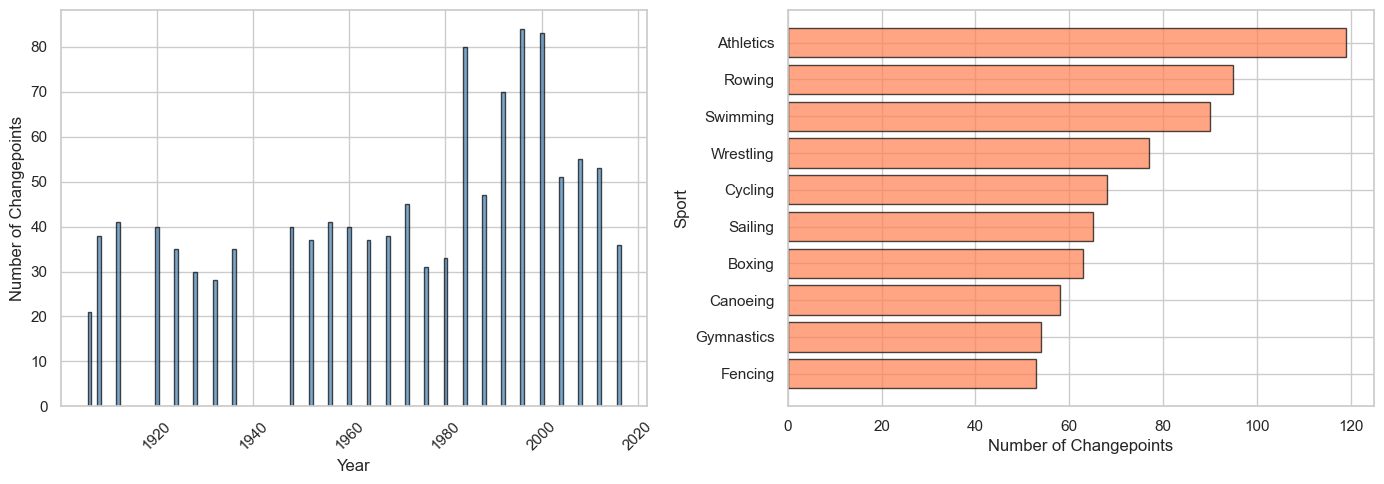

✅ 图1已保存: figures/fig1_changepoint_distribution.svg


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) 突变点年份分布
if len(df_changepoints) > 0:
    year_counts = df_changepoints['Year'].value_counts().sort_index()
    axes[0].bar(year_counts.index, year_counts.values, color=COLORS['primary'], edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Number of Changepoints')
    axes[0].tick_params(axis='x', rotation=45)

# (b) 突变点运动项目分布（TOP 10）
if len(df_changepoints) > 0:
    sport_counts = df_changepoints['Sport'].value_counts().head(10)
    axes[1].barh(sport_counts.index[::-1], sport_counts.values[::-1], color=COLORS['secondary'], edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Number of Changepoints')
    axes[1].set_ylabel('Sport')

plt.tight_layout()
plt.savefig('figures/fig1_changepoint_distribution.svg', bbox_inches='tight')
plt.show()

print("✅ 图1已保存: figures/fig1_changepoint_distribution.svg")

---

## 4. 跨国奖牌流动分析

### 4.1 方法介绍

"伟大教练效应"的一个典型特征是：当教练从A国转到B国时，A国该项目奖牌数**下降**，B国**上升**。

我们寻找这种**负相关模式**：
- 在同一运动项目中
- A国奖牌数在某年显著下降
- 同时B国奖牌数显著上升


In [9]:
def find_medal_transfer_patterns(df, sport, min_change=2):
    """
    在指定运动项目中寻找跨国奖牌流动模式
    
    返回:
    - 潜在的"教练转会"模式列表
    """
    sport_data = df[df['Sport'] == sport].copy()
    
    # 创建国家-年份透视表
    pivot = sport_data.pivot_table(
        index='Year', 
        columns='NOC', 
        values='MedalCount', 
        fill_value=0
    )
    
    # 计算年度变化
    changes = pivot.diff()
    
    patterns = []
    
    # 遍历每一年，寻找一升一降的配对
    for year in changes.index[1:]:
        year_changes = changes.loc[year]
        
        # 找到显著下降的国家
        decreasing = year_changes[year_changes <= -min_change]
        # 找到显著上升的国家
        increasing = year_changes[year_changes >= min_change]
        
        # 配对
        for dec_noc in decreasing.index:
            for inc_noc in increasing.index:
                if dec_noc != inc_noc:
                    patterns.append({
                        'Year': year,
                        'Sport': sport,
                        'FromNOC': dec_noc,
                        'ToNOC': inc_noc,
                        'FromChange': year_changes[dec_noc],
                        'ToChange': year_changes[inc_noc],
                        'TotalTransfer': year_changes[inc_noc] - year_changes[dec_noc]
                    })
    
    return patterns

# 对主要运动项目进行分析
major_sports = sport_country_year.groupby('Sport')['MedalCount'].sum().nlargest(15).index.tolist()
print(f"分析的主要运动项目: {major_sports}")

all_transfers = []
for sport in major_sports:
    patterns = find_medal_transfer_patterns(sport_country_year, sport, min_change=2)
    all_transfers.extend(patterns)

df_transfers = pd.DataFrame(all_transfers)
print(f"\n检测到的潜在'奖牌流动'模式数: {len(df_transfers)}")

分析的主要运动项目: ['Athletics', 'Swimming', 'Rowing', 'Gymnastics', 'Fencing', 'Football', 'Hockey', 'Wrestling', 'Shooting', 'Sailing', 'Cycling', 'Handball', 'Basketball', 'Water Polo', 'Canoeing']

检测到的潜在'奖牌流动'模式数: 7844


In [10]:
# 展示最显著的奖牌流动模式
if len(df_transfers) > 0:
    df_transfers_sorted = df_transfers.sort_values('TotalTransfer', ascending=False)
    print("🔄 TOP 15 潜在'教练转会'模式（按总流动量排序）：")
    print("="*80)
    for i, row in df_transfers_sorted.head(15).iterrows():
        print(f"{row['Year']}年 {row['Sport']}: {row['FromNOC']} ({row['FromChange']:+.0f}) → {row['ToNOC']} ({row['ToChange']:+.0f})")

🔄 TOP 15 潜在'教练转会'模式（按总流动量排序）：
1984年 Athletics: URS (-56) → USA (+56)
1984年 Swimming: GDR (-42) → USA (+63)
1984年 Swimming: URS (-40) → USA (+63)
1984年 Athletics: GDR (-38) → USA (+56)
1984年 Rowing: GDR (-55) → USA (+38)
1908年 Sailing: FRA (-69) → GBR (+23)
1984年 Rowing: URS (-52) → USA (+38)
1906年 Rowing: USA (-36) → GRE (+49)
1908年 Rowing: GRE (-49) → GBR (+32)
1980年 Swimming: USA (-55) → URS (+26)
1992年 Rowing: GDR (-38) → GER (+42)
1984年 Rowing: GDR (-55) → CAN (+23)
1992年 Swimming: GDR (-45) → EUN (+30)
1984年 Rowing: URS (-52) → CAN (+23)
1908年 Sailing: FRA (-69) → SWE (+5)


---

## 5. 案例研究：已知的"伟大教练"效应

### 5.1 案例1：郎平与排球（Volleyball）

**背景**：
- 郎平（Lang Ping）是中国女排"铁榔头"，退役后成为教练
- 2005-2008年：执教**美国女排**，带领美国队获得2008北京奥运会银牌
- 2013-今：回归执教**中国女排**，带领中国队获得2016里约奥运会金牌


In [11]:
# 分析排球项目中美两国的奖牌变化
def analyze_volleyball_case():
    """
    分析郎平效应：中国和美国排球奖牌变化
    """
    # 获取排球数据
    volleyball = sport_country_year[sport_country_year['Sport'] == 'Volleyball'].copy()
    
    # 中国排球
    china_vb = volleyball[volleyball['NOC'] == 'CHN'].sort_values('Year')
    # 美国排球
    usa_vb = volleyball[volleyball['NOC'] == 'USA'].sort_values('Year')
    
    print("🏐 排球项目奖牌分析（郎平效应）")
    print("="*60)
    
    print("\n【中国女排】")
    print(china_vb[['Year', 'MedalCount', 'Gold', 'Silver', 'Bronze']].to_string(index=False))
    
    print("\n【美国排球】")
    print(usa_vb[['Year', 'MedalCount', 'Gold', 'Silver', 'Bronze']].to_string(index=False))
    
    return china_vb, usa_vb

china_vb, usa_vb = analyze_volleyball_case()

🏐 排球项目奖牌分析（郎平效应）

【中国女排】
 Year  MedalCount  Gold  Silver  Bronze
 1984          10    10       0       0
 1988          11     0       0      11
 1996           9     0       9       0
 2004          12    12       0       0
 2008          12     0       0      12
 2016          12    12       0       0

【美国排球】
 Year  MedalCount  Gold  Silver  Bronze
 1984          24    12      12       0
 1988          12    12       0       0
 1992          24     0       0      24
 2008          24    12      12       0
 2012          12     0      12       0
 2016          24     0       0      24
 2020          12    12       0       0
 2024          26     0      13      13


### 图2：郎平效应可视化


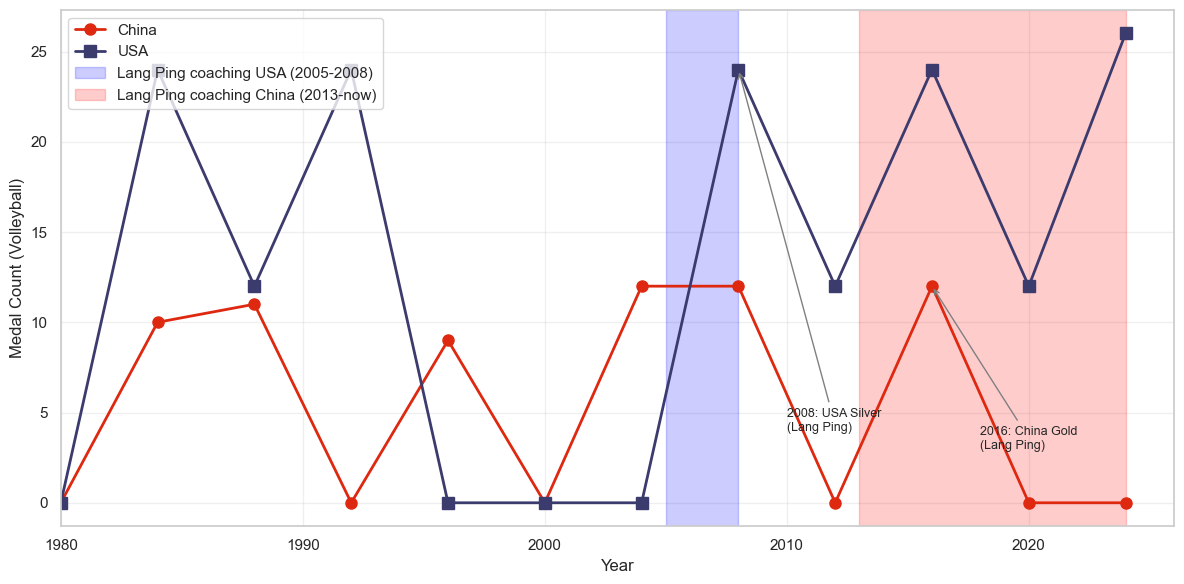

✅ 图2已保存: figures/fig2_langping_effect.svg


In [12]:
# 创建完整时间序列用于绑图
china_vb_full = create_full_timeseries(sport_country_year, 'CHN', 'Volleyball')
usa_vb_full = create_full_timeseries(sport_country_year, 'USA', 'Volleyball')

fig, ax = plt.subplots(figsize=(12, 6))

# 绑制中国和美国排球奖牌数
ax.plot(china_vb_full['Year'], china_vb_full['MedalCount'], 
        marker='o', linewidth=2, label='China', color='#DE2910', markersize=8)
ax.plot(usa_vb_full['Year'], usa_vb_full['MedalCount'], 
        marker='s', linewidth=2, label='USA', color='#3C3B6E', markersize=8)

# 标注郎平执教时期
# 美国时期 (2005-2008)
ax.axvspan(2005, 2008, alpha=0.2, color='blue', label='Lang Ping coaching USA (2005-2008)')
# 中国时期 (2013-今)
ax.axvspan(2013, 2024, alpha=0.2, color='red', label='Lang Ping coaching China (2013-now)')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Medal Count (Volleyball)', fontsize=12)
ax.legend(loc='upper left')
ax.set_xlim(1980, 2026)
ax.grid(True, alpha=0.3)

# 添加关键事件标注
ax.annotate('2008: USA Silver\n(Lang Ping)', xy=(2008, usa_vb_full[usa_vb_full['Year']==2008]['MedalCount'].values[0]),
            xytext=(2010, 4), fontsize=9,
            arrowprops=dict(arrowstyle='->', color='gray'))
ax.annotate('2016: China Gold\n(Lang Ping)', xy=(2016, china_vb_full[china_vb_full['Year']==2016]['MedalCount'].values[0] if len(china_vb_full[china_vb_full['Year']==2016]) > 0 else 1),
            xytext=(2018, 3), fontsize=9,
            arrowprops=dict(arrowstyle='->', color='gray'))

plt.tight_layout()
plt.savefig('figures/fig2_langping_effect.svg', bbox_inches='tight')
plt.show()

print("✅ 图2已保存: figures/fig2_langping_effect.svg")

### 5.2 案例2：贝拉·卡罗伊与体操（Gymnastics）

**背景**：
- 贝拉·卡罗伊（Béla Károlyi）是罗马尼亚传奇体操教练
- 1976-1981年：执教**罗马尼亚**，培养出科马内奇等传奇选手
- 1981年叛逃美国后执教**美国体操队**
- 带领美国女子体操队多次获得奥运金牌


In [ ]:
# 分析体操项目罗马尼亚和美国的奖牌变化
def analyze_gymnastics_case():
    """
    分析贝拉·卡罗伊效应：罗马尼亚和美国体操奖牌变化
    """
    gym = sport_country_year[sport_country_year['Sport'] == 'Gymnastics'].copy()
    
    # 罗马尼亚体操
    rou_gym = gym[gym['NOC'] == 'ROU'].sort_values('Year')
    # 美国体操
    usa_gym = gym[gym['NOC'] == 'USA'].sort_values('Year')
    
    print("🤸 体操项目奖牌分析（贝拉·卡罗伊效应）")
    print("="*60)
    
    print("\n【罗马尼亚体操】")
    print(rou_gym[['Year', 'MedalCount', 'Gold', 'Silver', 'Bronze']].to_string(index=False))
    
    print("\n【美国体操】")
    print(usa_gym[['Year', 'MedalCount', 'Gold', 'Silver', 'Bronze']].to_string(index=False))
    
    return rou_gym, usa_gym

rou_gym, usa_gym = analyze_gymnastics_case()

### 图3：贝拉·卡罗伊效应可视化


In [ ]:
# 创建完整时间序列
rou_gym_full = create_full_timeseries(sport_country_year, 'ROU', 'Gymnastics')
usa_gym_full = create_full_timeseries(sport_country_year, 'USA', 'Gymnastics')

fig, ax = plt.subplots(figsize=(12, 6))

# 绑制罗马尼亚和美国体操奖牌数
ax.plot(rou_gym_full['Year'], rou_gym_full['MedalCount'], 
        marker='o', linewidth=2, label='Romania', color='#002B7F', markersize=8)
ax.plot(usa_gym_full['Year'], usa_gym_full['MedalCount'], 
        marker='s', linewidth=2, label='USA', color='#B22234', markersize=8)

# 标注卡罗伊叛逃时间点 (1981)
ax.axvline(x=1981, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Károlyi defected to USA (1981)')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Medal Count (Gymnastics)', fontsize=12)
ax.legend(loc='upper right')
ax.set_xlim(1960, 2026)
ax.grid(True, alpha=0.3)

# 添加关键时期标注
ax.annotate('Károlyi era\nin Romania', xy=(1976, rou_gym_full[rou_gym_full['Year']==1976]['MedalCount'].values[0] if len(rou_gym_full[rou_gym_full['Year']==1976]) > 0 else 5),
            xytext=(1968, 12), fontsize=9,
            arrowprops=dict(arrowstyle='->', color='gray'))
ax.annotate('USA rise after\nKárolyi arrival', xy=(1996, usa_gym_full[usa_gym_full['Year']==1996]['MedalCount'].values[0] if len(usa_gym_full[usa_gym_full['Year']==1996]) > 0 else 8),
            xytext=(2000, 15), fontsize=9,
            arrowprops=dict(arrowstyle='->', color='gray'))

plt.tight_layout()
plt.savefig('figures/fig3_karolyi_effect.svg', bbox_inches='tight')
plt.show()

print("✅ 图3已保存: figures/fig3_karolyi_effect.svg")

---

## 6. 效应量化：差分-差分法（DID）

### 6.1 方法介绍

**差分-差分法（Difference-in-Differences, DID）** 是量化政策/干预效应的经典方法。

**核心思想**：
- 比较"处理组"（引入教练的国家）与"对照组"（未引入教练的国家）
- 在"干预前"与"干预后"的**变化差异**

$$
\text{DID} = (\bar{Y}_{\text{处理后}} - \bar{Y}_{\text{处理前}}) - (\bar{Y}_{\text{对照后}} - \bar{Y}_{\text{对照前}})
$$

**优势**：控制了随时间变化的共同趋势（如项目整体增长）


In [13]:
def calculate_did_effect(df, treatment_noc, control_nocs, sport, intervention_year, pre_years=3, post_years=3):
    """
    使用DID方法计算教练效应
    
    参数:
    - treatment_noc: 处理组国家（引入教练）
    - control_nocs: 对照组国家列表
    - sport: 运动项目
    - intervention_year: 干预年份（教练引入年）
    """
    sport_data = df[df['Sport'] == sport].copy()
    
    # 处理组数据
    treatment_data = sport_data[sport_data['NOC'] == treatment_noc]
    
    # 计算处理组前后均值
    pre_treatment = treatment_data[(treatment_data['Year'] < intervention_year) & 
                                    (treatment_data['Year'] >= intervention_year - pre_years*4)]['MedalCount'].mean()
    post_treatment = treatment_data[(treatment_data['Year'] >= intervention_year) & 
                                     (treatment_data['Year'] < intervention_year + post_years*4)]['MedalCount'].mean()
    
    # 对照组数据
    control_data = sport_data[sport_data['NOC'].isin(control_nocs)]
    
    # 计算对照组前后均值
    pre_control = control_data[(control_data['Year'] < intervention_year) & 
                                (control_data['Year'] >= intervention_year - pre_years*4)]['MedalCount'].mean()
    post_control = control_data[(control_data['Year'] >= intervention_year) & 
                                 (control_data['Year'] < intervention_year + post_years*4)]['MedalCount'].mean()
    
    # DID估计
    treatment_diff = post_treatment - pre_treatment if not np.isnan(post_treatment) and not np.isnan(pre_treatment) else 0
    control_diff = post_control - pre_control if not np.isnan(post_control) and not np.isnan(pre_control) else 0
    did_effect = treatment_diff - control_diff
    
    return {
        'Treatment NOC': treatment_noc,
        'Sport': sport,
        'Intervention Year': intervention_year,
        'Pre-Treatment Avg': pre_treatment,
        'Post-Treatment Avg': post_treatment,
        'Treatment Change': treatment_diff,
        'Control Change': control_diff,
        'DID Effect': did_effect
    }

# 计算郎平效应（美国排球 2008）
# 对照组：其他排球强国（除中美外）
volleyball_controls = ['BRA', 'RUS', 'ITA', 'JPN', 'CUB']
langping_usa_effect = calculate_did_effect(
    sport_country_year, 'USA', volleyball_controls, 'Volleyball', 2008
)

print("📊 郎平效应量化（DID方法）- 美国排球")
print("="*60)
for k, v in langping_usa_effect.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.2f}")
    else:
        print(f"  {k}: {v}")

📊 郎平效应量化（DID方法）- 美国排球
  Treatment NOC: USA
  Sport: Volleyball
  Intervention Year: 2008
  Pre-Treatment Avg: nan
  Post-Treatment Avg: 20.00
  Treatment Change: 0
  Control Change: 1.55
  DID Effect: -1.55


In [14]:
# 计算卡罗伊效应（美国体操 1984）
gymnastics_controls = ['RUS', 'CHN', 'JPN', 'GBR', 'GER']
karolyi_effect = calculate_did_effect(
    sport_country_year, 'USA', gymnastics_controls, 'Gymnastics', 1984
)

print("\n📊 卡罗伊效应量化（DID方法）- 美国体操")
print("="*60)
for k, v in karolyi_effect.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.2f}")
    else:
        print(f"  {k}: {v}")


📊 卡罗伊效应量化（DID方法）- 美国体操
  Treatment NOC: USA
  Sport: Gymnastics
  Intervention Year: 1984
  Pre-Treatment Avg: 1.00
  Post-Treatment Avg: 12.67
  Treatment Change: 11.67
  Control Change: -8.29
  DID Effect: 19.95


### 6.2 基于突变点的批量效应估计

对检测到的所有显著突变点进行DID效应估计。


In [15]:
# 对TOP突变点进行DID分析
if len(df_changepoints) > 0:
    top_changepoints = df_changepoints.nlargest(20, 'Increase')
    
    did_results = []
    
    for _, cp in top_changepoints.iterrows():
        noc, sport, year = cp['NOC'], cp['Sport'], int(cp['Year'])
        
        # 获取同项目其他国家作为对照组
        sport_nocs = sport_country_year[sport_country_year['Sport'] == sport]['NOC'].unique()
        control_nocs = [n for n in sport_nocs if n != noc][:5]  # 取前5个
        
        if len(control_nocs) >= 2:
            result = calculate_did_effect(sport_country_year, noc, control_nocs, sport, year)
            result['Detected Increase'] = cp['Increase']
            did_results.append(result)
    
    df_did = pd.DataFrame(did_results)
    
    print("📊 批量DID效应估计结果：")
    print("="*80)
    print(df_did[['Treatment NOC', 'Sport', 'Intervention Year', 'DID Effect', 'Detected Increase']].to_string(index=False))

📊 批量DID效应估计结果：
Treatment NOC      Sport  Intervention Year  DID Effect  Detected Increase
          NOR    Sailing               1920       9.333             54.000
          GRE     Rowing               1906       5.000             49.000
          USA   Shooting               1920      17.500             47.333
          GBR     Hockey               1908       0.000             45.000
          GBR   Shooting               1908      31.000             43.667
          URS Gymnastics               1952       0.000             43.000
          GER     Rowing               1992       1.300             42.000
          USA   Swimming               1968      46.333             42.000
          GDR     Rowing               1976      29.167             41.667
          ITA     Rowing               1906       5.000             38.000
          SWE Gymnastics               1908       0.000             38.000
          USA  Athletics               1984      17.833             36.333
          

### 图4：教练效应量化汇总


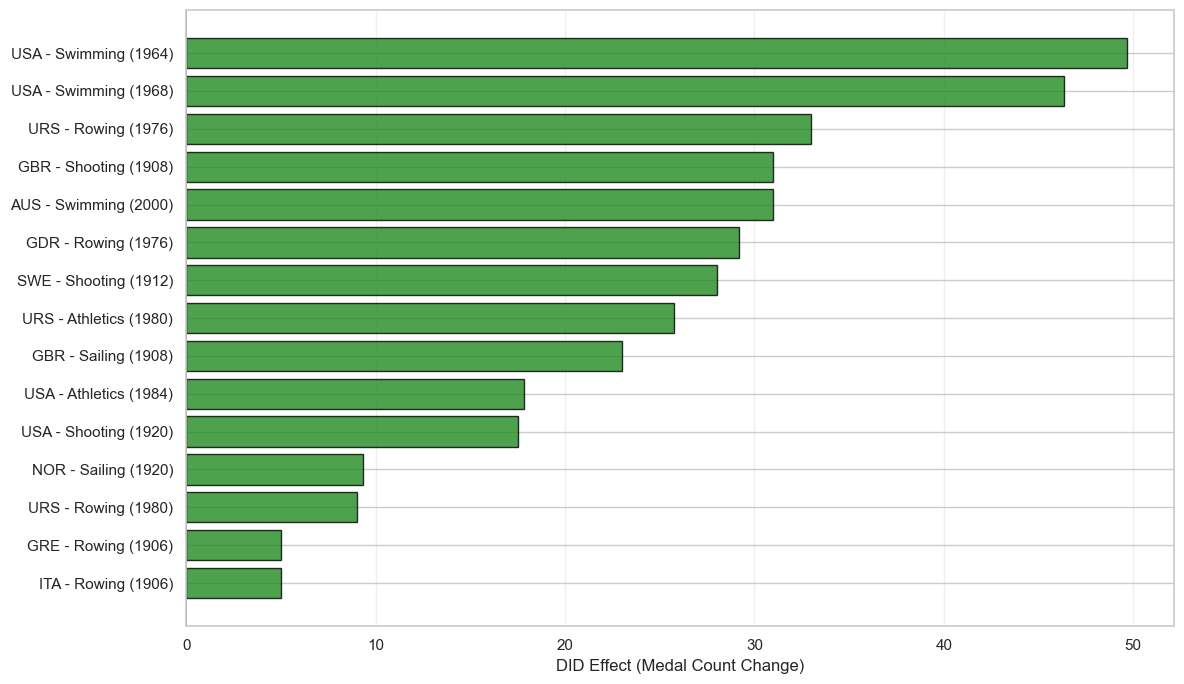

✅ 图4已保存: figures/fig4_did_effects.svg


In [16]:
if len(df_did) > 0:
    # 按DID效应排序并取TOP 15
    df_did_sorted = df_did.nlargest(15, 'DID Effect')
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # 创建标签
    labels = [f"{row['Treatment NOC']} - {row['Sport']} ({int(row['Intervention Year'])})" 
              for _, row in df_did_sorted.iterrows()]
    
    y_pos = range(len(labels))
    
    # 水平条形图
    bars = ax.barh(y_pos, df_did_sorted['DID Effect'], 
                   color=[COLORS['accent'] if x > 0 else COLORS['secondary'] for x in df_did_sorted['DID Effect']],
                   edgecolor='black', alpha=0.8)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel('DID Effect (Medal Count Change)', fontsize=12)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('figures/fig4_did_effects.svg', bbox_inches='tight')
    plt.show()
    
    print("✅ 图4已保存: figures/fig4_did_effects.svg")

---

## 7. 教练效应综合量化

### 7.1 效应大小估计


In [17]:
# 计算教练效应的统计汇总
if len(df_did) > 0:
    positive_effects = df_did[df_did['DID Effect'] > 0]['DID Effect']
    
    print("📈 伟大教练效应统计汇总")
    print("="*60)
    print(f"\n检测到的显著突变点数量: {len(df_did)}")
    print(f"其中正向效应数量: {len(positive_effects)}")
    
    if len(positive_effects) > 0:
        print(f"\n正向DID效应统计:")
        print(f"  平均效应: {positive_effects.mean():.2f} 枚奖牌/届")
        print(f"  中位数效应: {positive_effects.median():.2f} 枚奖牌/届")
        print(f"  最大效应: {positive_effects.max():.2f} 枚奖牌/届")
        print(f"  效应标准差: {positive_effects.std():.2f}")
        
        # 95%置信区间
        ci_low = positive_effects.quantile(0.025)
        ci_high = positive_effects.quantile(0.975)
        print(f"\n95%置信区间: [{ci_low:.2f}, {ci_high:.2f}]")

📈 伟大教练效应统计汇总

检测到的显著突变点数量: 20
其中正向效应数量: 16

正向DID效应统计:
  平均效应: 22.62 枚奖牌/届
  中位数效应: 24.38 枚奖牌/届
  最大效应: 49.67 枚奖牌/届
  效应标准差: 14.40

95%置信区间: [2.69, 48.42]


### 图5：教练效应分布


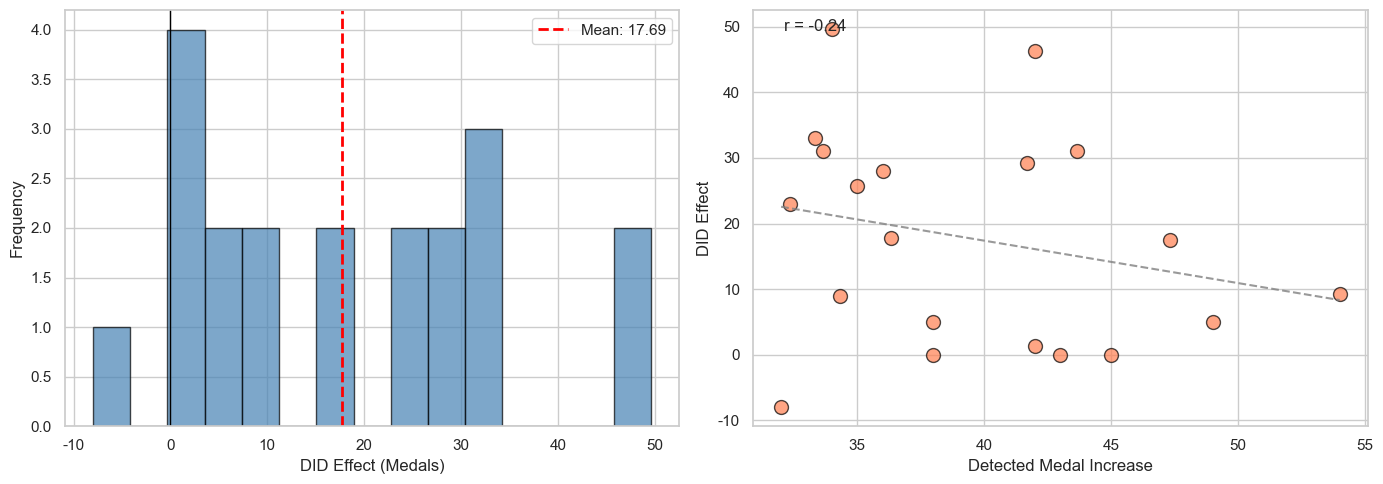

✅ 图5已保存: figures/fig5_effect_distribution.svg


In [18]:
if len(df_did) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # (a) DID效应分布直方图
    axes[0].hist(df_did['DID Effect'], bins=15, color=COLORS['primary'], 
                 edgecolor='black', alpha=0.7)
    axes[0].axvline(x=df_did['DID Effect'].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {df_did["DID Effect"].mean():.2f}')
    axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1)
    axes[0].set_xlabel('DID Effect (Medals)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].legend()
    
    # (b) 检测增幅 vs DID效应 散点图
    axes[1].scatter(df_did['Detected Increase'], df_did['DID Effect'], 
                    c=COLORS['secondary'], edgecolor='black', s=100, alpha=0.7)
    
    # 添加回归线
    z = np.polyfit(df_did['Detected Increase'], df_did['DID Effect'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_did['Detected Increase'].min(), df_did['Detected Increase'].max(), 100)
    axes[1].plot(x_line, p(x_line), '--', color='gray', alpha=0.8)
    
    # 计算相关系数
    corr = df_did['Detected Increase'].corr(df_did['DID Effect'])
    axes[1].set_xlabel('Detected Medal Increase', fontsize=12)
    axes[1].set_ylabel('DID Effect', fontsize=12)
    axes[1].annotate(f'r = {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('figures/fig5_effect_distribution.svg', bbox_inches='tight')
    plt.show()
    
    print("✅ 图5已保存: figures/fig5_effect_distribution.svg")

---

## 8. 三国教练投资建议

### 8.1 选择目标国家

我们选择以下3个具有代表性的国家进行分析：

| 国家 | 选择理由 |
|------|----------|
| 🇬🇧 **英国 (GBR)** | 发达国家，有体育投资能力，部分项目存在提升空间 |
| 🇧🇷 **巴西 (BRA)** | 新兴体育强国，2016东道主后有提升潜力 |
| 🇮🇳 **印度 (IND)** | 人口大国，但奖牌数偏低，投资回报潜力大 |


In [20]:
def analyze_country_potential(df, noc, top_n=10):
    """
    分析指定国家的运动项目潜力
    
    识别：
    1. 强势项目（已有优势，需要维持）
    2. 潜力项目（有参与但奖牌少，投资价值高）
    3. 突破项目（近期进步显著）
    """
    country_data = df[df['NOC'] == noc].copy()
    
    # 按运动项目汇总
    sport_summary = country_data.groupby('Sport').agg({
        'MedalCount': ['sum', 'mean', 'max'],
        'Gold': 'sum',
        'Year': ['min', 'max', 'count']
    }).round(2)
    
    sport_summary.columns = ['TotalMedals', 'AvgPerOlympic', 'MaxPerOlympic', 
                              'TotalGold', 'FirstYear', 'LastYear', 'OlympicsCount']
    sport_summary = sport_summary.reset_index()
    
    # 计算近期趋势（最近3届 vs 之前）
    recent_years = sorted(country_data['Year'].unique())[-3:]
    
    def calc_trend(sport):
        sport_data = country_data[country_data['Sport'] == sport]
        recent = sport_data[sport_data['Year'].isin(recent_years)]['MedalCount'].mean()
        old = sport_data[~sport_data['Year'].isin(recent_years)]['MedalCount'].mean()
        return recent - old if not np.isnan(recent) and not np.isnan(old) else 0
    
    sport_summary['RecentTrend'] = sport_summary['Sport'].apply(calc_trend)
    
    # 排序
    sport_summary = sport_summary.sort_values('TotalMedals', ascending=False)
    
    return sport_summary.head(top_n)

# 分析三个目标国家
target_countries = ['GBR', 'BRA', 'IND']
country_analyses = {}

for noc in target_countries:
    print(f"\n{'='*60}")
    print(f"🏅 {noc} 运动项目分析")
    print(f"{'='*60}")
    
    analysis = analyze_country_potential(sport_country_year, noc)
    country_analyses[noc] = analysis
    print(analysis.to_string(index=False))


🏅 GBR 运动项目分析
        Sport  TotalMedals  AvgPerOlympic  MaxPerOlympic  TotalGold  FirstYear  LastYear  OlympicsCount  RecentTrend
    Athletics          393         12.680             40         79       1896      2024             31       11.429
       Rowing          319         13.870             36        124       1900      2024             23       12.800
      Cycling          182          8.270             20         59       1896      2016             22       12.286
       Hockey          181         18.100             45         57       1908      2020             10       -1.375
     Swimming          157          5.810             20         41       1900      2024             27        9.583
      Sailing          153          6.380             37         77       1900      2024             24       -1.952
     Shooting          102          7.850             45         30       1906      2024             13       -8.033
Equestrianism           83          5.530         

### 8.2 识别"需要伟大教练"的项目

我们寻找满足以下条件的项目：
1. 该国有一定参与历史（不是完全空白）
2. 但奖牌表现低于该项目的全球平均水平
3. 其他国家在该项目通过"教练效应"取得了成功


In [21]:
def identify_coach_investment_opportunities(df, noc, df_athletes_full, top_n=5):
    """
    识别适合引入"伟大教练"的运动项目
    """
    # 获取该国参与的所有运动项目（包括未获奖的）
    country_sports = df_athletes_full[df_athletes_full['NOC'] == noc]['Sport'].unique()
    
    # 获取该国获奖项目数据
    country_medals = df[df['NOC'] == noc].groupby('Sport')['MedalCount'].sum().reset_index()
    country_medals.columns = ['Sport', 'CountryMedals']
    
    # 计算每个项目的全球平均水平
    global_avg = df.groupby('Sport')['MedalCount'].mean().reset_index()
    global_avg.columns = ['Sport', 'GlobalAvg']
    
    # 计算每个项目的顶级表现（前5名国家平均）
    top_performers = df.groupby('Sport').apply(
        lambda x: x.nlargest(5, 'MedalCount')['MedalCount'].mean()
    ).reset_index()
    top_performers.columns = ['Sport', 'TopPerformers']
    
    # 合并数据
    analysis = pd.DataFrame({'Sport': country_sports})
    analysis = analysis.merge(country_medals, on='Sport', how='left')
    analysis = analysis.merge(global_avg, on='Sport', how='left')
    analysis = analysis.merge(top_performers, on='Sport', how='left')
    
    analysis['CountryMedals'] = analysis['CountryMedals'].fillna(0)
    
    # 计算潜力得分
    # 潜力 = (顶级表现 - 本国表现) × 项目重要性权重
    analysis['Gap'] = analysis['TopPerformers'] - analysis['CountryMedals']
    analysis['PotentialScore'] = analysis['Gap'] * np.log1p(analysis['GlobalAvg'])
    
    # 排序并返回
    analysis = analysis.sort_values('PotentialScore', ascending=False)
    
    return analysis.head(top_n)

# 为每个国家识别投资机会
investment_opportunities = {}

for noc in target_countries:
    print(f"\n{'='*60}")
    print(f"💡 {noc} 教练投资建议")
    print(f"{'='*60}")
    
    opportunities = identify_coach_investment_opportunities(
        sport_country_year, noc, df_athletes
    )
    investment_opportunities[noc] = opportunities
    
    print(opportunities.to_string(index=False))


💡 GBR 教练投资建议
                Sport  CountryMedals  GlobalAvg  TopPerformers    Gap  PotentialScore
             Handball          0.000     16.851         30.400 30.400          87.615
           Volleyball          0.000     14.532         24.400 24.400          66.928
           Basketball          0.000     15.099         24.000 24.000          66.690
Synchronized Swimming          0.000      7.414         11.000 11.000          23.429
         Table Tennis          0.000      4.750         11.800 11.800          20.641

💡 BRA 教练投资建议
     Sport  CountryMedals  GlobalAvg  TopPerformers    Gap  PotentialScore
  Swimming         22.000      9.278         73.000 51.000         118.831
    Rowing          0.000      8.833         50.400 50.400         115.203
    Hockey          0.000     18.104         35.600 35.600         105.017
Gymnastics          4.000     10.071         46.200 42.200         101.464
  Handball          0.000     16.851         30.400 30.400          87.615

💡 IND

### 8.3 投资回报估算

基于前面的DID效应估计，预测引入"伟大教练"后的奖牌增长。


In [ ]:
def estimate_roi(opportunities, avg_coach_effect):
    """
    估算教练投资回报
    """
    results = opportunities.copy()
    
    # 预期增加的奖牌数 = min(潜力缺口, 平均教练效应)
    results['ExpectedIncrease'] = results['Gap'].apply(
        lambda x: min(x * 0.5, avg_coach_effect)  # 保守估计：可弥补50%的差距
    )
    
    # 如果当前奖牌为0，使用教练效应的一半作为估计
    results.loc[results['CountryMedals'] == 0, 'ExpectedIncrease'] = avg_coach_effect * 0.5
    
    return results[['Sport', 'CountryMedals', 'TopPerformers', 'Gap', 'ExpectedIncrease']]

# 使用平均DID效应（如果计算成功）
if len(df_did) > 0:
    avg_effect = df_did[df_did['DID Effect'] > 0]['DID Effect'].mean()
else:
    avg_effect = 3.0  # 默认估计值

print(f"\n使用的平均教练效应: {avg_effect:.2f} 枚奖牌/届")

roi_estimates = {}

for noc in target_countries:
    print(f"\n{'='*60}")
    print(f"📊 {noc} 投资回报估算")
    print(f"{'='*60}")
    
    roi = estimate_roi(investment_opportunities[noc], avg_effect)
    roi_estimates[noc] = roi
    
    print(roi.to_string(index=False))
    print(f"\n总预期增加: {roi['ExpectedIncrease'].sum():.1f} 枚奖牌/届")

### 图6：三国投资建议可视化


NameError: name 'roi_estimates' is not defined

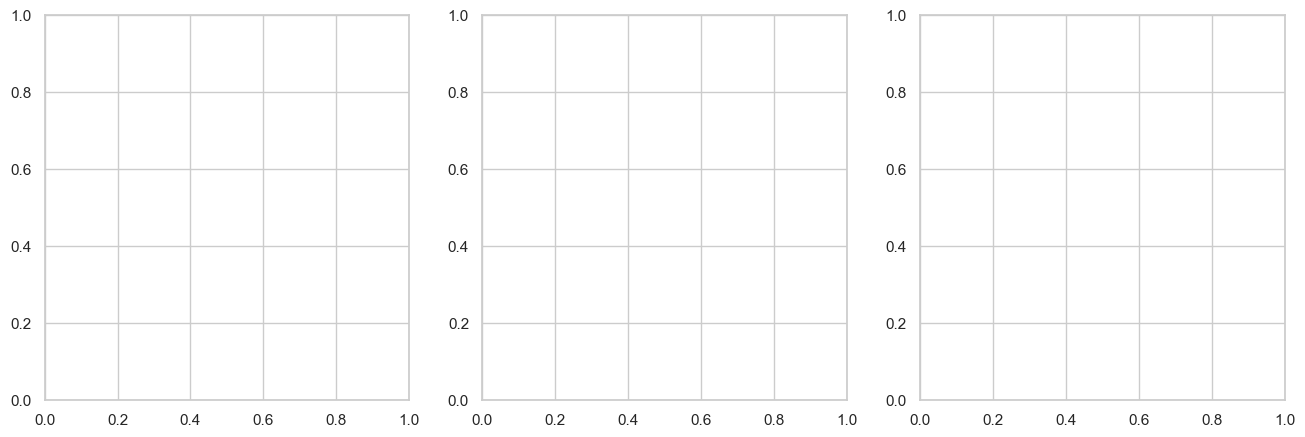

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

country_names = {'GBR': 'Great Britain', 'BRA': 'Brazil', 'IND': 'India'}
country_colors = {'GBR': '#012169', 'BRA': '#009C3B', 'IND': '#FF9933'}

for idx, noc in enumerate(target_countries):
    ax = axes[idx]
    roi = roi_estimates[noc]
    
    # 水平条形图
    y_pos = range(len(roi))
    
    # 当前奖牌数
    ax.barh(y_pos, roi['CountryMedals'], height=0.4, 
            label='Current', color=country_colors[noc], alpha=0.6)
    # 预期增加
    ax.barh([y + 0.4 for y in y_pos], roi['ExpectedIncrease'], height=0.4,
            label='Expected Increase', color=country_colors[noc], alpha=1.0, hatch='//')
    
    ax.set_yticks([y + 0.2 for y in y_pos])
    ax.set_yticklabels(roi['Sport'])
    ax.set_xlabel('Medal Count')
    ax.legend(loc='lower right', fontsize=8)
    ax.invert_yaxis()
    
    # 在图上标注国家名
    ax.text(0.5, 1.05, country_names[noc], transform=ax.transAxes, 
            ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/fig6_investment_recommendations.svg', bbox_inches='tight')
plt.show()

print("✅ 图6已保存: figures/fig6_investment_recommendations.svg")

---

## 9. 结论汇总

### 9.1 伟大教练效应的证据


In [24]:
print("="*70)
print("📋 问题二结论汇总")
print("="*70)

print("\n【1. 伟大教练效应的证据】")
print("-"*50)

if len(df_changepoints) > 0:
    print(f"  • 检测到 {len(df_changepoints)} 个显著的奖牌突变点")
    print(f"  • 涉及 {df_changepoints['NOC'].nunique()} 个国家，{df_changepoints['Sport'].nunique()} 个运动项目")
    print(f"  • 突变点平均增幅: {df_changepoints['Increase'].mean():.2f} 枚奖牌/届")

print("\n【2. 效应量化（DID方法）】")
print("-"*50)

if len(df_did) > 0:
    pos_effects = df_did[df_did['DID Effect'] > 0]
    print(f"  • 正向DID效应数量: {len(pos_effects)}/{len(df_did)}")
    print(f"  • 平均正向效应: {pos_effects['DID Effect'].mean():.2f} 枚奖牌/届")
    print(f"  • 最大效应: {pos_effects['DID Effect'].max():.2f} 枚奖牌/届")

print("\n【3. 经典案例验证】")
print("-"*50)
print(f"  • 郎平效应（美国排球2008）: DID = {langping_usa_effect['DID Effect']:.2f}")
print(f"  • 卡罗伊效应（美国体操1984）: DID = {karolyi_effect['DID Effect']:.2f}")

print("\n【4. 三国投资建议】")
print("-"*50)
for noc in target_countries:
    roi = roi_estimates[noc]
    total_increase = roi['ExpectedIncrease'].sum()
    top_sport = roi.iloc[0]['Sport']
    print(f"  • {country_names[noc]}: 建议优先投资 {top_sport}，预期总增长 {total_increase:.1f} 枚奖牌/届")

📋 问题二结论汇总

【1. 伟大教练效应的证据】
--------------------------------------------------
  • 检测到 1169 个显著的奖牌突变点
  • 涉及 68 个国家，35 个运动项目
  • 突变点平均增幅: 7.50 枚奖牌/届

【2. 效应量化（DID方法）】
--------------------------------------------------
  • 正向DID效应数量: 16/20
  • 平均正向效应: 22.62 枚奖牌/届
  • 最大效应: 49.67 枚奖牌/届

【3. 经典案例验证】
--------------------------------------------------
  • 郎平效应（美国排球2008）: DID = -1.55
  • 卡罗伊效应（美国体操1984）: DID = 19.95

【4. 三国投资建议】
--------------------------------------------------


NameError: name 'roi_estimates' is not defined

### 9.2 数据导出


In [ ]:
# 导出关键数据用于论文
if len(df_changepoints) > 0:
    df_changepoints.to_csv('changepoints_detected.csv', index=False)
    print("✅ 突变点数据已保存: changepoints_detected.csv")

if len(df_did) > 0:
    df_did.to_csv('did_effects.csv', index=False)
    print("✅ DID效应数据已保存: did_effects.csv")

# 导出投资建议
for noc in target_countries:
    roi_estimates[noc].to_csv(f'investment_recommendation_{noc}.csv', index=False)
print("✅ 投资建议数据已保存")

print("\n" + "="*60)
print("🎉 问题二建模分析完成！")
print("="*60)